# Group Equivariant Network

In [ ]:
from torchvision.transforms.functional import rotate as torchvision_rotate
import numpy as np
import torch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
class C4:
  @staticmethod
  def product(r: int, s: int) -> int:
    return (r + s) % 4

  @staticmethod
  def inverse(r: int) -> int:
    return (4 - r) % 4


class D4:

  @staticmethod
  def product(a: tuple, b: tuple) -> tuple:
    f = (a[0] + b[0])%2
    if a[0] == 1 and b[0] == 0:
      return (f, C4.product(a[1], C4.inverse(b[1])))
    elif a[0] == 1:
      return (f, C4.product(C4.inverse(a[1]), b[1]))
    return (f, C4.product(a[1], b[1]))


  @staticmethod
  def inverse(g: int) -> int:
    if g[0] == 0:
      return (g[0], C4.inverse(g[1]))
    return (1, g[1])

In [ ]:
def rotate(x: torch.Tensor, r: int, n: int=4) -> torch.Tensor:
  if n == 4:
    return x.rot90(r, dims=(-2, -1))
  else:
    angle = (360.0 / n) * r
    if len(x.shape) == 4:
      return torchvision_rotate(x, angle)
    return torchvision_rotate(x.reshape(x.shape[0]*x.shape[1], *x.shape[2:]), angle).reshape(*x.shape)

def rotate_pn(y: torch.Tensor, r: int, n: int=4) -> torch.Tensor:
  assert len(y.shape) >= 3
  assert y.shape[-3] == n

  y = torch.roll(y, r, dims=-3)
  return rotate(y, r, n)

def rotate_p4m(y: torch.Tensor, g: int) -> torch.Tensor:
  assert len(y.shape) >= 3
  assert y.shape[-3] == 8

  f = g // 4
  r = g % 4

  y_split = y.reshape(*y.shape[:-3], 2, 4, *y.shape[-2:])
  if f == 1:
    rolled_y = torch.flip(y_split, dims=[-4, -3, -2])
    y_split = torch.roll(rolled_y, 1, dims=-3)

  return rotate_pn(y_split, r, 4).reshape(*y.shape)

In [ ]:
class LiftingConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True, group: str = 'pn', n: int = 4):
    super(LiftingConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.group = group

    assert self.group in ['pn', 'd4'], print('Not implemented')

    if self.group == 'pn':
      self.stabilizer_size = n
      self.rotate_func = lambda w, r: rotate(w, r, self.stabilizer_size)
    elif self.group == 'd4':
      self.stabilizer_size = 8
      self.rotate_func = lambda w, r: torch.rot90(w, k=r, dims=[-2, -1]) if r < 4 else torch.rot90(torch.flip(w, dims=[-2]), k=r, dims=[-2, -1])

    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:
    _filter = None
    _bias = None

    _filter = torch.stack([self.rotate_func(self.weight, r) for r in range(self.stabilizer_size)], dim=1)

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, self.stabilizer_size)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, self.stabilizer_size)
    assert _filter.shape == (self.out_channels, self.stabilizer_size, self.in_channels, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * self.stabilizer_size, self.in_channels, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * self.stabilizer_size)

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, self.stabilizer_size, out.shape[-2], out.shape[-1])

In [ ]:
class GroupConv2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, bias: bool = True, group: str = 'pn', n: int = 4):

    super(GroupConv2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = 1
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.group = group

    assert self.group in ['pn', 'd4'], print('Not implemented')

    if self.group == 'pn':
      self.stabilizer_size = n
      self.rotate_func = lambda w, r: rotate_pn(w, r, self.stabilizer_size)
    elif self.group == 'd4':
      self.stabilizer_size = 8
      self.rotate_func = rotate_p4m


    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, self.stabilizer_size, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:

    _filter = None
    _bias = None

    _filter = torch.stack([self.rotate_func(self.weight, r) for r in range(self.stabilizer_size)], dim=1)

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, self.stabilizer_size)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    assert _bias.shape == (self.out_channels, self.stabilizer_size)
    assert _filter.shape == (self.out_channels, self.stabilizer_size, self.in_channels, self.stabilizer_size, self.kernel_size, self.kernel_size)

    _filter = _filter.reshape(self.out_channels * self.stabilizer_size, self.in_channels * self.stabilizer_size, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * self.stabilizer_size)

    x = x.view(x.shape[0], self.in_channels*self.stabilizer_size, x.shape[-2], x.shape[-1])

    out = torch.conv2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, self.stabilizer_size, out.shape[-2], out.shape[-1])

In [ ]:
class GroupConvTranspose2d(torch.nn.Module):

  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0,
               stride: int = 1, bias: bool = True, group: str = 'pn', n: int = 4):

    super(GroupConvTranspose2d, self).__init__()

    self.kernel_size = kernel_size
    self.stride = stride
    self.dilation = 1
    self.padding = padding
    self.out_channels = out_channels
    self.in_channels = in_channels
    self.group = group

    assert self.group in ['pn', 'd4'], print('Not implemented')

    if self.group == 'pn':
      self.stabilizer_size = n
      self.rotate_func = lambda w, r: rotate_pn(w, r, self.stabilizer_size)
    elif self.group == 'd4':
      self.stabilizer_size = 8
      self.rotate_func = rotate_p4m


    self.weight = None

    self.weight = torch.nn.Parameter(torch.Tensor(in_channels, out_channels, self.stabilizer_size, kernel_size, kernel_size))
    torch.nn.init.normal_(self.weight, mean=0.0, std=1.0 / np.sqrt(out_channels * in_channels))

    self.bias = None
    if bias:
      self.bias = torch.nn.Parameter(torch.ones(out_channels)*0.01)

  def build_filter(self) ->torch.Tensor:

    _filter = None
    _bias = None

    _filter = torch.stack([self.rotate_func(self.weight, r) for r in range(self.stabilizer_size)], dim=1)

    if self.bias is not None:
      _bias = self.bias[:, None].expand(-1, self.stabilizer_size)
    else:
      _bias = None

    return _filter, _bias

  def forward(self, x: torch.Tensor) -> torch.Tensor:

    _filter, _bias = self.build_filter()

    _filter = _filter.reshape(self.in_channels * self.stabilizer_size, self.out_channels * self.stabilizer_size, self.kernel_size, self.kernel_size)
    _bias = _bias.reshape(self.out_channels * self.stabilizer_size)

    x = x.view(x.shape[0], self.in_channels*self.stabilizer_size, x.shape[-2], x.shape[-1])

    out = torch.conv_transpose2d(x, _filter,
                       stride=self.stride,
                       padding=self.padding,
                       dilation=self.dilation,
                       bias=_bias)

    return out.view(-1, self.out_channels, self.stabilizer_size, out.shape[-2], out.shape[-1])

# Segmentation

In [ ]:
from skimage.io import imread
import os
from skimage.transform import resize
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torchsummary import summary

from IPython.display import clear_output
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Data

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2023-12-09 22:09:31--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2023-12-09 22:09:31--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c25ab8f12b639681948e5fedc.dl.dropboxusercontent.com/cd/0/inline/CJHBasUmygrmBnbzggLEO9GL2JWJ24diX9qljmLE_Bp0hXaPgJ7wnptPHUbDlYaiVQZRBGTGdSTtuhJjLAU7B9EU4hvkAUgSazOtvvaUKEqf9G_Sx0ihuiXTYrRFBzXkuaw/file# [following]
--2023-12-09 22:09:32--  https://uc7c25ab8f12b639681948e5fedc.dl.dropboxusercontent.com/cd/0/inline/CJHBasUmygrmBnbzggLEO9GL2JWJ24diX9qljmLE_Bp0hXaPgJ7wnptPHUbDlYaiVQZRBGTGdSTtuhJjLAU7B9EU4hvkAUgSazOtvvaUKEqf9G_Sx0

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


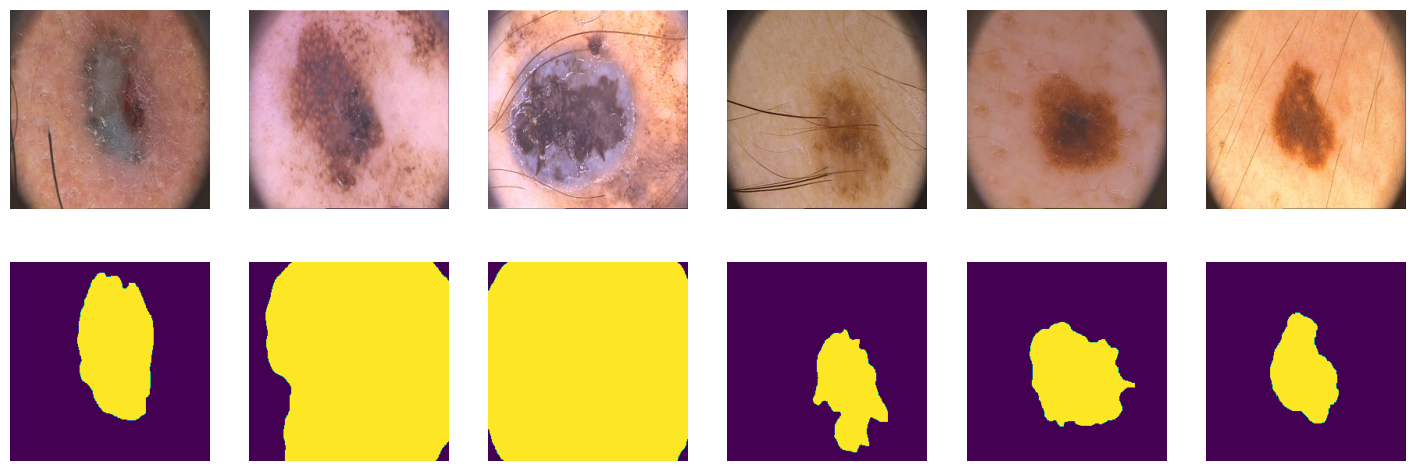

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

## Help functions

In [ ]:
def bce_loss(y_real, y_pred):
    return torch.mean(torch.clamp(y_pred, 0) - y_pred * y_real + torch.log(1 + torch.exp(-torch.abs(y_pred))))

def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.sigmoid(y_pred)
    loss = torch.clamp((1 - y_pred)**2 * y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred), eps)
    return -loss.mean()

def dice_loss(y_real, y_pred):
    num = 2 * y_real * y_pred
    den = (y_real + y_pred)
    res = 1 - (num / den).mean()
    return res

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = (outputs.squeeze(1) > 0)
    labels = labels.squeeze(1) > 0
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))

    iou = (intersection + SMOOTH) / (union + SMOOTH)

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

    return thresholded  #

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
          Y_pred = model(X_batch.to(device)).to(device)
          scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data) #, Y_label[0], Y_pred[0]

In [ ]:
def score_model_rotated(model, metric, data, n=4):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
          X_batch = rotate(X_batch, 1, n)
          Y_label = rotate(Y_label, 1, n)
          Y_pred = model(X_batch.to(device)).to(device)
          scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data) #, Y_label[0], Y_pred[0]

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, compute_score=False):
    #X_val, Y_val = next(iter(data_val))
    train_loss = []
    val_loss = []
    scores = []

    for epoch in range(epochs):
      #  tic = time()
      #  print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch).to(device)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item()

        train_loss.append(avg_loss / len(data_tr))
       # toc = time()
       # print('train loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        avg_loss = 0
        with torch.no_grad():
          for X_batch, Y_batch in data_val:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch).to(device)
            loss = loss_fn(Y_batch, Y_pred)
            avg_loss += loss.item()

        val_loss.append(avg_loss / len(data_val))
        if compute_score:
          score = score_model(model, iou_pytorch, data_val)
          scores.append(score)


        #Y_hat = model(X_val.to(device)).detach().cpu() # detach and put into cpu
        Y_hat = Y_pred.detach().cpu()
        X_val = X_batch.cpu()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        if compute_score:
          plt.suptitle('%d / %d - train loss: %f - val loss: %f - val score: %f' %
                       (epoch+1, epochs, train_loss[-1], val_loss[-1], score))
        else:
          plt.suptitle('%d / %d - train loss: %f - val loss: %f' % (epoch+1, epochs, train_loss[-1], val_loss[-1]))
        plt.show()

    if compute_score:
      return train_loss, val_loss, scores
    else:
      return train_loss, val_loss

## Experiments with upsampling

In [ ]:
# size = (256, 256)
# X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
# Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

# X = np.array(X, np.float32)
# Y = np.array(Y, np.float32)
# print(f'Loaded {len(X)} images')

np.random.seed(0)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
# ix = array([ 18, 170, 107,  98, 177, 182,   5, 146,  12, 152,  61, 125, 180,
#        154,  80,   7,  33, 130,  37,  74, 183, 145,  45, 159,  60, 123,
#        179, 185, 122,  44,  16,  55, 150, 111,  22, 189, 129,   4,  83,
#        106, 134,  66,  26, 113, 168,  63,   8,  75, 118, 143,  71, 124,
#        184,  97, 149,  24,  30, 160,  40,  56, 131,  96, 181,  19, 153,
#         92,  54, 163,  51,  86, 139,  90, 137, 101, 144,  89, 109,  14,
#         27, 141, 187,  46, 138, 195, 108,  62,   2,  59, 136, 197,  43,
#         10, 194,  73, 196, 178, 175, 126,  93, 112, 158, 191,  50,   0,
#         94, 110,  95,  64, 167,  41,  69,  49,  48,  85,  13, 161,  23,
#        186, 135,  20,  15,  78, 104,  52, 100,  76,   3, 116, 164, 198,
#          6,  68,  84, 121, 155, 171, 156,  91, 199,  11, 119, 102,  35,
#         57,  65,   1, 120, 162,  42, 105, 132, 173,  17,  38, 133,  53,
#        157, 128,  34,  28, 114, 151,  31, 166, 127, 176,  32, 142, 169,
#        147,  29,  99,  82,  79, 115, 148, 193,  72,  77,  25, 165,  81,
#        188, 174, 190,  39,  58, 140,  88,  70,  87,  36,  21,   9, 103,
#         67, 192, 117,  47, 172])

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)

        self.enc_conv0 = nn.Sequential(nn.Conv2d(3, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32),
                                       nn.Conv2d(32, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32))
        self.pool0 = nn.MaxPool2d(2)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64))
        self.pool1 = nn.MaxPool2d(2);

        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128))
        self.pool2 = nn.MaxPool2d(2);

        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 256, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256))
        self.pool3 = nn.MaxPool2d(2);

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(256, 256, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(256),
                                       nn.Conv2d(256, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128))
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(128, 128, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(128),
                                       nn.Conv2d(128, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64))
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear') # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(64, 64, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(64),
                                       nn.Conv2d(64, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32))
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear') # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(32, 32, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(32),
                                       nn.Conv2d(32, 1, (3, 3), padding=1),
                                       nn.ReLU(),
                                       nn.BatchNorm2d(1))

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x.to(device)))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # decoder
        d0 = self.dec_conv0(self.upsample0(e3))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [ ]:
class GroupSegNet(nn.Module):
    def __init__(self, input_channels: int = 3, channels: tuple = None, group: str = 'pn', n: int = 4):
        super().__init__()

        if channels is None:
          channels = [1, 16, 32, 64, 128]
        if group == 'pn':
          stabilizer_size = n
        elif group == 'd4':
          stabilizer_size = 8

        self.enc_layers = [nn.Sequential(LiftingConv2d(input_channels, channels[1], 3, padding=1, group=group, n=n),
                                          nn.ReLU(),
                                          nn.BatchNorm3d(channels[1]),
                                          GroupConv2d(channels[1], channels[1], 3, padding=1, group=group, n=n),
                                          nn.ReLU(),
                                          nn.BatchNorm3d(channels[1]),
                                          nn.MaxPool3d((1, 2, 2), (1, 2, 2)))]

        for i in range(2, len(channels)):
          self.enc_layers.append(nn.Sequential(GroupConv2d(channels[i - 1], channels[i], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               nn.MaxPool3d((1, 2, 2), (1, 2, 2))))

        self.enc_layers = nn.ModuleList(self.enc_layers)

        self.dec_layers = []
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        for i in range(len(channels) - 1, 0, -1):
          self.dec_layers.append(nn.Sequential(GroupConv2d(channels[i], channels[i], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i - 1], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i - 1])))

        self.dec_layers = nn.ModuleList(self.dec_layers)
        self.pooling = nn.MaxPool3d((stabilizer_size, 1, 1), (1, 1, 1), (0, 0, 0))


    def forward(self, input):
        # encoder
        x = input.to(device)
        for layer in self.enc_layers:
          x = layer(x)

        # decoder
        for layer in self.dec_layers:
          upsampled = self.upsample(x.reshape(x.shape[0] * x.shape[1], *x.shape[2:]))
          upsampled = upsampled.reshape(x.shape[0], x.shape[1], *upsampled.shape[1:])
          x = layer(upsampled)

        output = self.pooling(x)
        return output.reshape(output.shape[0], output.shape[1]*output.shape[2], *output.shape[3:])

    def before_pooling(self, input):
      with torch.no_grad():
        x = input.to(device)
        for layer in self.enc_layers:
          x = layer(x)

        for layer in self.dec_layers:
          upsampled = self.upsample(x.reshape(x.shape[0] * x.shape[1], *x.shape[2:]))
          upsampled = upsampled.reshape(x.shape[0], x.shape[1], *upsampled.shape[1:])
          x = layer(upsampled)

      return x

In [ ]:
model = SegNet().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
              ReLU-2         [-1, 32, 256, 256]               0
       BatchNorm2d-3         [-1, 32, 256, 256]              64
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
       BatchNorm2d-6         [-1, 32, 256, 256]              64
         MaxPool2d-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          18,496
              ReLU-9         [-1, 64, 128, 128]               0
      BatchNorm2d-10         [-1, 64, 128, 128]             128
           Conv2d-11         [-1, 64, 128, 128]          36,928
             ReLU-12         [-1, 64, 128, 128]               0
      BatchNorm2d-13         [-1, 64, 128, 128]             128
        MaxPool2d-14           [-1, 64,

In [ ]:
p4_model = GroupSegNet().to(device)
summary(p4_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     LiftingConv2d-1      [-1, 16, 4, 256, 256]             448
              ReLU-2      [-1, 16, 4, 256, 256]               0
       BatchNorm3d-3      [-1, 16, 4, 256, 256]              32
       GroupConv2d-4      [-1, 16, 4, 256, 256]           9,232
              ReLU-5      [-1, 16, 4, 256, 256]               0
       BatchNorm3d-6      [-1, 16, 4, 256, 256]              32
         MaxPool3d-7      [-1, 16, 4, 128, 128]               0
       GroupConv2d-8      [-1, 32, 4, 128, 128]          18,464
              ReLU-9      [-1, 32, 4, 128, 128]               0
      BatchNorm3d-10      [-1, 32, 4, 128, 128]              64
      GroupConv2d-11      [-1, 32, 4, 128, 128]          36,896
             ReLU-12      [-1, 32, 4, 128, 128]               0
      BatchNorm3d-13      [-1, 32, 4, 128, 128]              64
        MaxPool3d-14        [-1, 32, 4,

In [ ]:
#Equivariance check
train_img = torch.randn(1, 3, 256, 256)
pred_mask = p4_model(train_img)

r = 2
rotated_img = rotate(train_img, r=r)
pred_rotated_mask = p4_model(rotated_img)
print(torch.max(torch.abs(rotate(pred_mask, r=r) - pred_rotated_mask)))
torch.allclose(rotate(pred_mask, r=r), pred_rotated_mask, atol=1e-3, rtol=1e-3)

tensor(0.0001, device='cuda:0', grad_fn=<MaxBackward1>)


True

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
p6_model = GroupSegNet(channels=[1, 16, 32, 64, 89], group='pn', n=6).to(device)
summary(p6_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     LiftingConv2d-1      [-1, 16, 6, 256, 256]             448
              ReLU-2      [-1, 16, 6, 256, 256]               0
       BatchNorm3d-3      [-1, 16, 6, 256, 256]              32
       GroupConv2d-4      [-1, 16, 6, 256, 256]          13,840
              ReLU-5      [-1, 16, 6, 256, 256]               0
       BatchNorm3d-6      [-1, 16, 6, 256, 256]              32
         MaxPool3d-7      [-1, 16, 6, 128, 128]               0
       GroupConv2d-8      [-1, 32, 6, 128, 128]          27,680
              ReLU-9      [-1, 32, 6, 128, 128]               0
      BatchNorm3d-10      [-1, 32, 6, 128, 128]              64
      GroupConv2d-11      [-1, 32, 6, 128, 128]          55,328
             ReLU-12      [-1, 32, 6, 128, 128]               0
      BatchNorm3d-13      [-1, 32, 6, 128, 128]              64
        MaxPool3d-14        [-1, 32, 6,

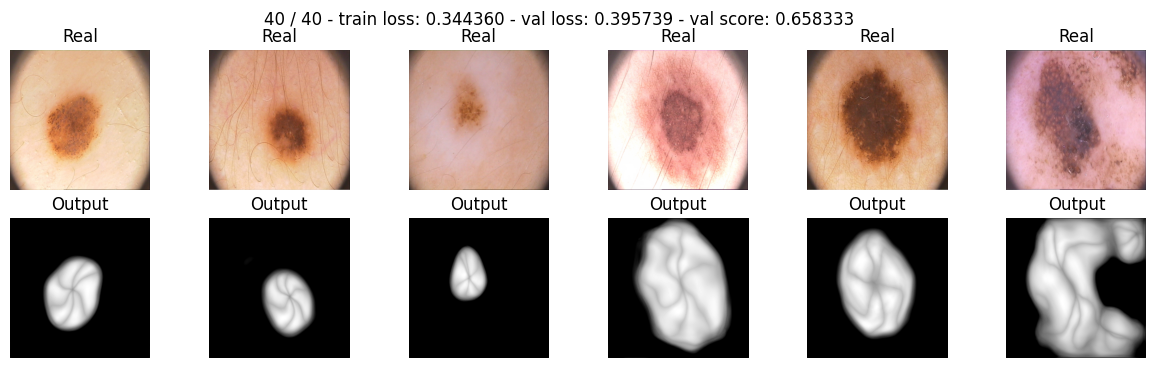

In [ ]:
max_epochs = 40
optimizer = torch.optim.Adam(p6_model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(p6_model, optimizer, bce_loss, max_epochs, data_tr, data_val, compute_score=True)

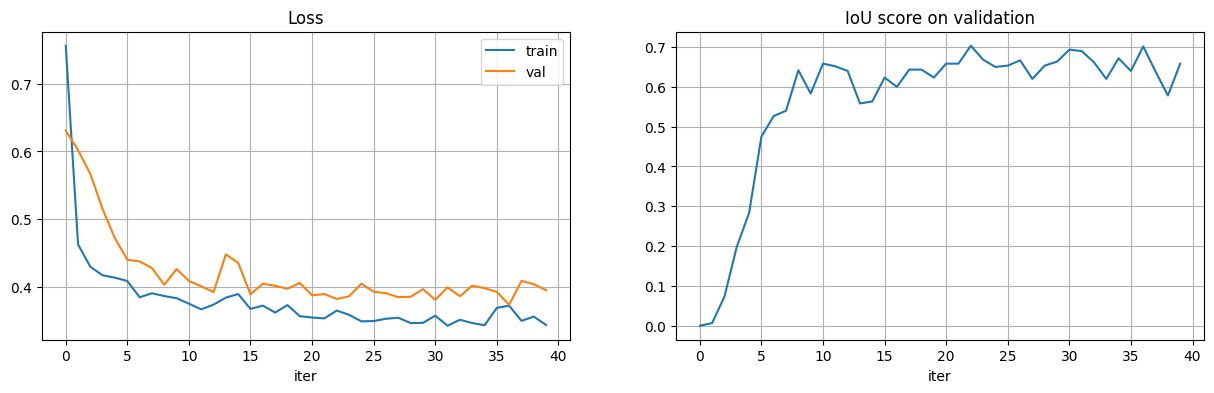

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(p6_model, iou_pytorch, data_tr)

0.7850000262260437

In [ ]:
score_model_rotated(p6_model, iou_pytorch, data_tr)

0.759000039100647

In [ ]:
score_model(p6_model, iou_pytorch, data_ts)

0.7300000389417013

In [ ]:
score_model(p6_model, iou_pytorch, data_val)

0.6583333611488342

In [ ]:
d4_model = GroupSegNet(channels=[1, 16, 32, 64, 64], group='d4').to(device)
summary(d4_model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     LiftingConv2d-1      [-1, 16, 8, 256, 256]             448
              ReLU-2      [-1, 16, 8, 256, 256]               0
       BatchNorm3d-3      [-1, 16, 8, 256, 256]              32
       GroupConv2d-4      [-1, 16, 8, 256, 256]          18,448
              ReLU-5      [-1, 16, 8, 256, 256]               0
       BatchNorm3d-6      [-1, 16, 8, 256, 256]              32
         MaxPool3d-7      [-1, 16, 8, 128, 128]               0
       GroupConv2d-8      [-1, 32, 8, 128, 128]          36,896
              ReLU-9      [-1, 32, 8, 128, 128]               0
      BatchNorm3d-10      [-1, 32, 8, 128, 128]              64
      GroupConv2d-11      [-1, 32, 8, 128, 128]          73,760
             ReLU-12      [-1, 32, 8, 128, 128]               0
      BatchNorm3d-13      [-1, 32, 8, 128, 128]              64
        MaxPool3d-14        [-1, 32, 8,

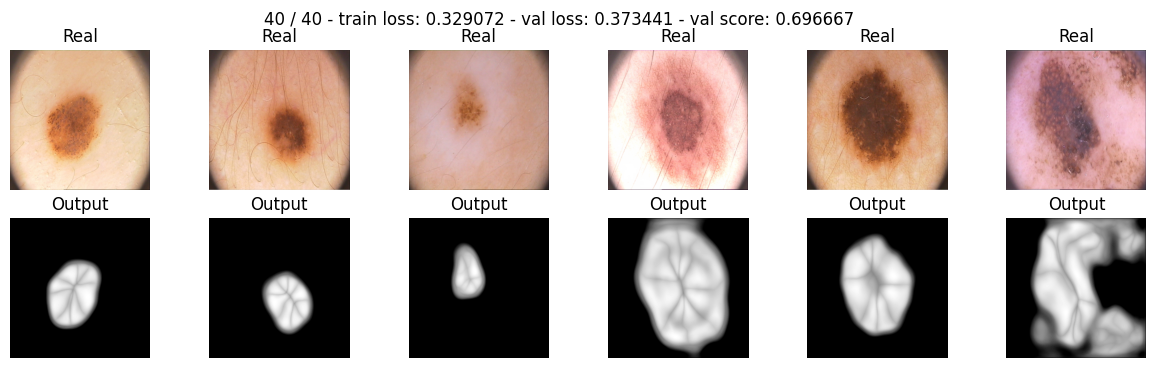

In [ ]:
max_epochs = 40
optimizer = torch.optim.Adam(d4_model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(d4_model, optimizer, bce_loss, max_epochs, data_tr, data_val, compute_score=True)

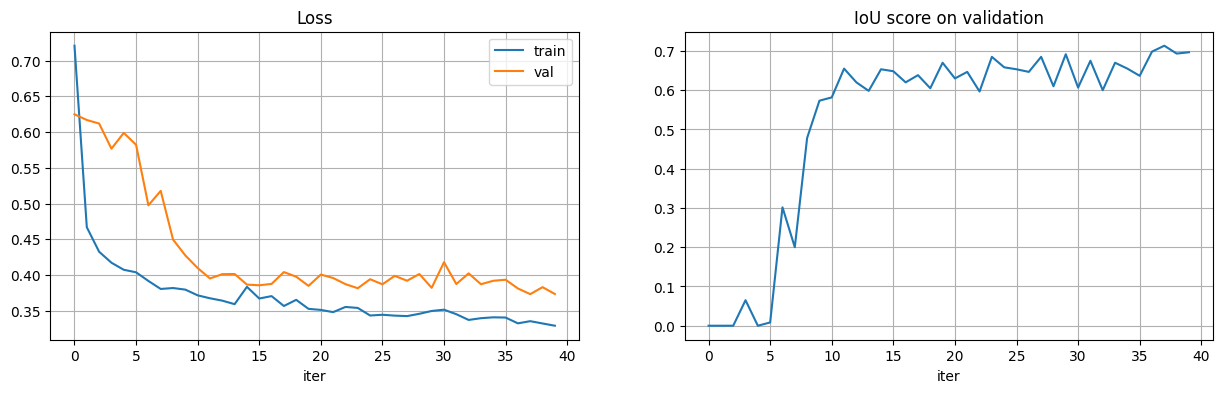

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(d4_model, iou_pytorch, data_ts)

0.7450000643730164

In [ ]:
score_model(d4_model, iou_pytorch, data_tr)

0.8480000495910645

In [ ]:
score_model(d4_model, iou_pytorch, data_val)

0.6966666777928671

In [ ]:
score_model_rotated(d4_model, iou_pytorch, data_tr)

0.8480000376701355

In [ ]:
torch.save(d4_model.state_dict(), 'd4_upsampling.pth')

KeyboardInterrupt: ignored

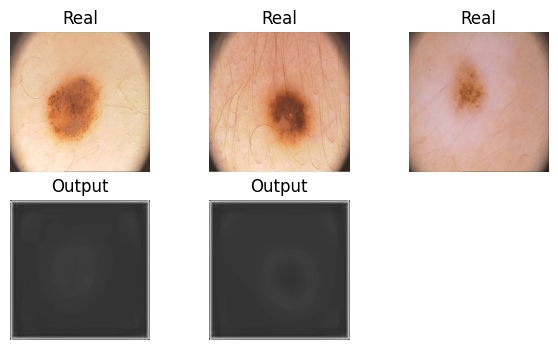

In [ ]:
p4_model = GroupSegNet().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(p4_model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(p4_model, optimizer, bce_loss, max_epochs, data_tr, data_val, compute_score=True)
#2 min (40 epochs)

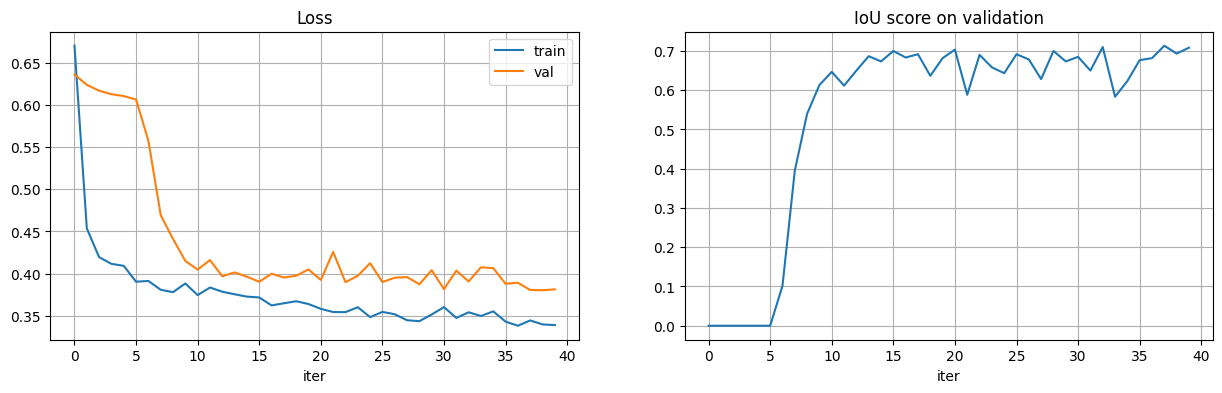

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(p4_model, iou_pytorch, data_ts)

0.7750000556310018

In [ ]:
score_model(p4_model, iou_pytorch, data_tr)

0.8730000257492065

In [ ]:
score_model(p4_model, iou_pytorch, data_val)

0.7083333532015482

In [ ]:
torch.save(p4_model.state_dict(), 'p4_upsampling.pth')

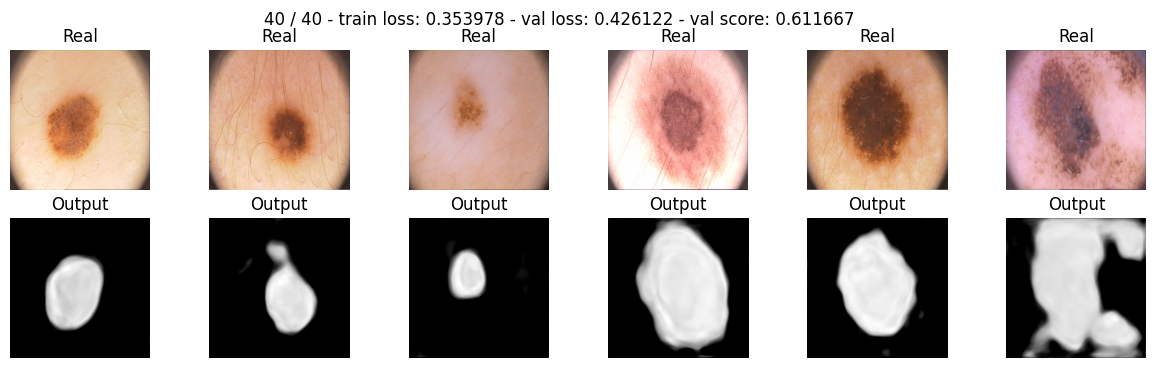

In [ ]:
max_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, compute_score=True)
#2 min

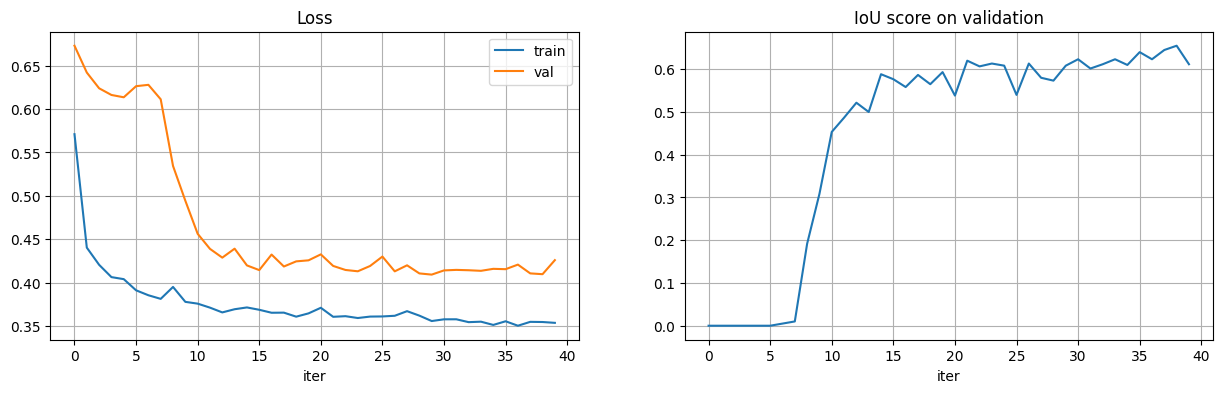

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_ts)

0.7183333436648051

In [ ]:
score_model(model, iou_pytorch, data_tr)

0.8850000143051148

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6116666793823242

In [ ]:
score_model_rotated(model, iou_pytorch, data_tr)

0.6270000219345093

In [ ]:
score_model_rotated(model, iou_pytorch, data_ts)

0.6466667056083679

In [ ]:
torch.save(p4_model.state_dict(), 'p4_model.pth')

### Augmentations

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

np.random.seed(0)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

Loaded 200 images


In [ ]:
class TrainDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        r =  np.random.randint(4)
        x = rotate(x, r)
        y = rotate(y, r)
        if torch.rand(1) > 0.5:
          x = torch.flip(x, dims=[-2])
          y = torch.flip(y, dims=[-2])

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
dataset_tr = TrainDataset(torch.tensor(np.rollaxis(X[tr], 3, 1)), torch.tensor(Y[tr, np.newaxis]))

In [ ]:
batch_size = 20
data_transform = DataLoader(dataset_tr,
                     batch_size=batch_size, shuffle=True)

data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

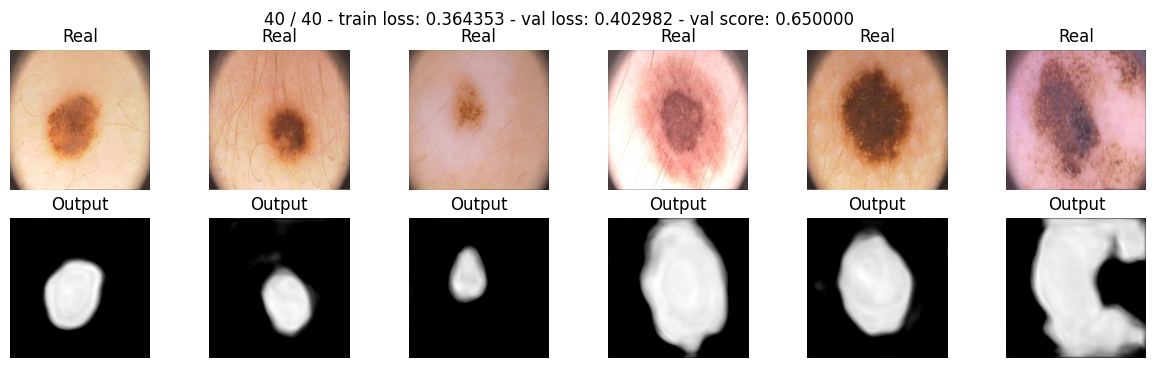

In [ ]:
model = SegNet().to(device)
max_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(model, optimizer, bce_loss, max_epochs, data_transform, data_val, compute_score=True)
# 2 min

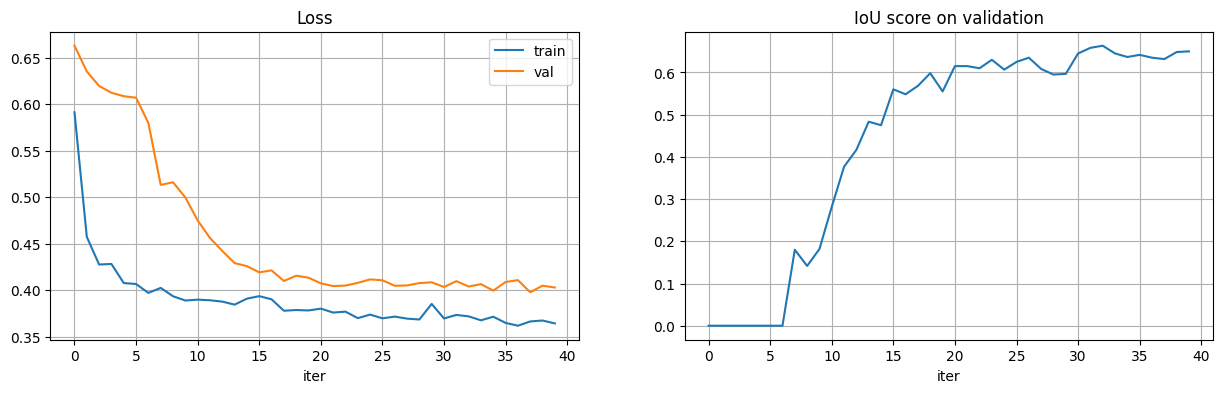

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_ts)

0.7350000143051147

In [ ]:
score_model(model, iou_pytorch, data_tr)

0.84000004529953

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6500000357627869

In [ ]:
score_model_rotated(model, iou_pytorch, data_tr)

0.8380000591278076

In [ ]:
score_model_rotated(model, iou_pytorch, data_ts)

0.7383333841959635

In [ ]:
torch.save(model.state_dict(), 'cnn_upsampling_transforms.pth')

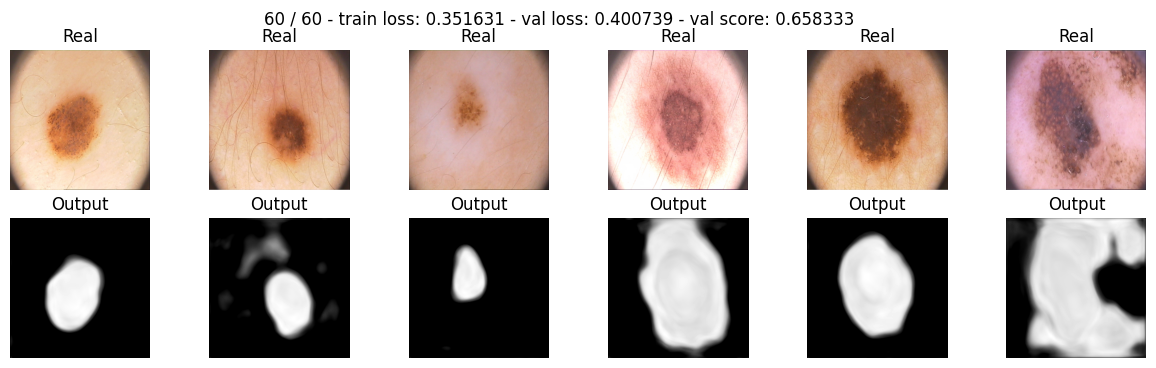

In [ ]:
model = SegNet().to(device)
max_epochs = 60
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(model, optimizer, bce_loss, max_epochs, data_transform, data_val, compute_score=True)
#3 min

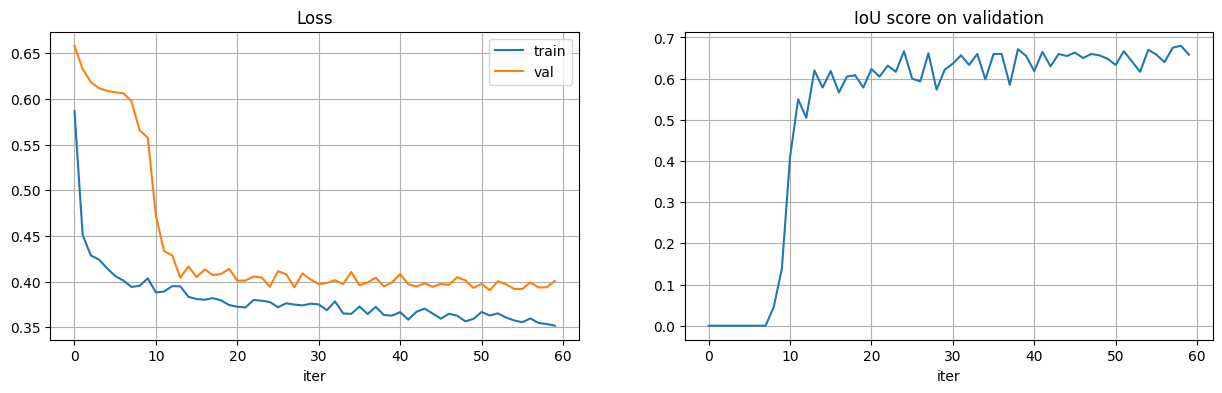

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_ts)

0.7666666507720947

In [ ]:
score_model(model, iou_pytorch, data_tr)

0.859000051021576

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6583333412806193

In [ ]:
score_model_rotated(model, iou_pytorch, data_tr)

0.8510000467300415

In [ ]:
score_model_rotated(model, iou_pytorch, data_ts)

0.7716667056083679

In [ ]:
torch.save(model.state_dict(), 'cnn_upsampling_transforms.pth')

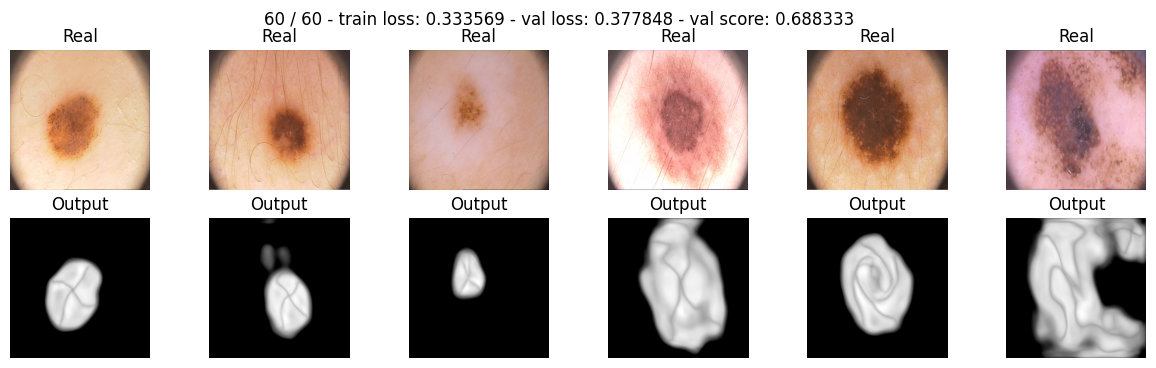

In [ ]:
p4_model = GroupSegNet().to(device)
max_epochs = 60
optimizer = torch.optim.Adam(p4_model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(p4_model, optimizer, bce_loss, max_epochs, data_transform, data_val, compute_score=True)
#4 min (40 epochs)

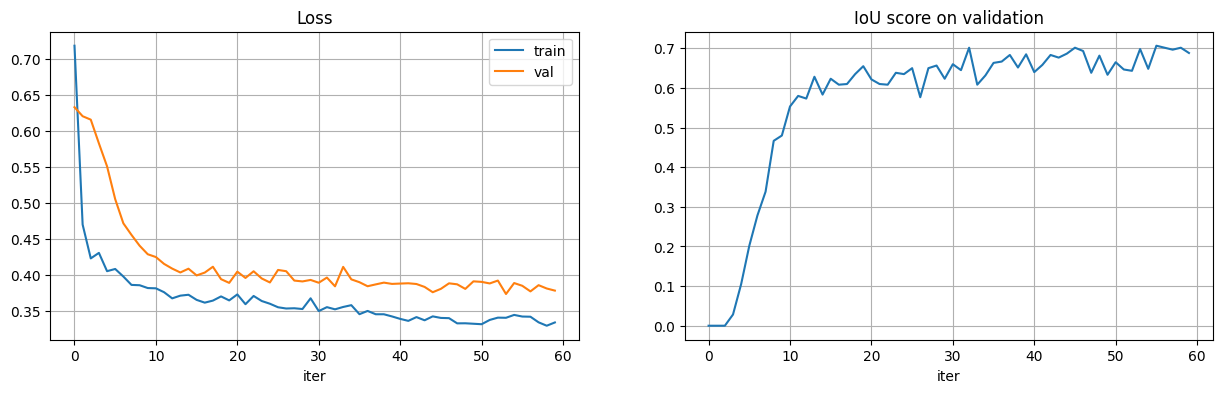

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(p4_model, iou_pytorch, data_ts)

0.7883333563804626

In [ ]:
score_model(p4_model, iou_pytorch, data_tr)

0.8940000295639038

In [ ]:
score_model(p4_model, iou_pytorch, data_val)

0.6883333524068197

In [ ]:
torch.save(p4_model.state_dict(), 'p4_upsampling_transforms.pth')

## Experiments with transposed convolutions

In [ ]:
size = (257, 257)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

np.random.seed(0)
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

Loaded 200 images


In [ ]:
class SegNetTranspose(nn.Module):
    def __init__(self, input_channels: int = 3, channels: tuple = None):
        super().__init__()

        if channels is None:
          channels = [1, 32, 64, 128, 256]

        self.enc_blocks = []
        input_dim = input_channels
        for dim in channels[1:]:
          self.enc_blocks.append(nn.Sequential(nn.Conv2d(input_dim, dim, (3, 3), padding=1),
                                                nn.ReLU(),
                                                nn.BatchNorm2d(dim),
                                                nn.Conv2d(dim, dim, (3, 3), padding=1),
                                                nn.ReLU(),
                                                nn.BatchNorm2d(dim),
                                                nn.MaxPool2d(3, stride=2, padding=1)))
          input_dim = dim

        self.enc_blocks = nn.ModuleList(self.enc_blocks)

        self.dec_blocks = []
        for dim in channels[-2::-1]:
          self.dec_blocks.append(nn.Sequential(nn.ConvTranspose2d(input_dim, input_dim, 3, stride=2, padding=1),
                                                nn.ReLU(),
                                                nn.BatchNorm2d(input_dim),
                                                nn.Conv2d(input_dim, dim, (3, 3), padding=1),
                                                nn.ReLU(),
                                                nn.BatchNorm2d(dim)))
          input_dim = dim

        self.dec_blocks = nn.ModuleList(self.dec_blocks)

    def forward(self, x):
        # encoder
        x = x.to(device)
        for block in self.enc_blocks:
          x = block(x)

        # decoder
        for block in self.dec_blocks:
          x = block(x)

        return x

In [ ]:
model = SegNetTranspose().to(device)
summary(model, (3, 257, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 257, 257]             896
              ReLU-2         [-1, 32, 257, 257]               0
       BatchNorm2d-3         [-1, 32, 257, 257]              64
            Conv2d-4         [-1, 32, 257, 257]           9,248
              ReLU-5         [-1, 32, 257, 257]               0
       BatchNorm2d-6         [-1, 32, 257, 257]              64
         MaxPool2d-7         [-1, 32, 129, 129]               0
            Conv2d-8         [-1, 64, 129, 129]          18,496
              ReLU-9         [-1, 64, 129, 129]               0
      BatchNorm2d-10         [-1, 64, 129, 129]             128
           Conv2d-11         [-1, 64, 129, 129]          36,928
             ReLU-12         [-1, 64, 129, 129]               0
      BatchNorm2d-13         [-1, 64, 129, 129]             128
        MaxPool2d-14           [-1, 64,

In [ ]:
#Equivariance check (cnn is not equivariant)
train_img = torch.randn(1, 3, 257, 257)
pred_mask = model(train_img)

r = 2
rotated_img = rotate(train_img, r=r)
pred_rotated_mask = model(rotated_img)

print(torch.max(torch.abs(rotate(pred_mask, r=r) - pred_rotated_mask)))
torch.allclose(rotate(pred_mask, r=r), pred_rotated_mask, atol=1e-4, rtol=1e-4)

tensor(17.8324, device='cuda:0', grad_fn=<MaxBackward1>)


False

In [ ]:
class GroupSegNetTranspose(nn.Module):
    def __init__(self, input_channels: int = 3, channels: tuple = None, group: str = 'pn', n: int = 4):
        super().__init__()

        if channels is None:
          channels = [1, 16, 32, 64, 128]
        if group == 'pn':
          stabilizer_size = n
        elif group == 'd4':
          stabilizer_size = 8

        self.enc_blocks = [nn.Sequential(LiftingConv2d(input_channels, channels[1], 3, padding=1, group=group, n=n),
                                          nn.ReLU(),
                                          nn.BatchNorm3d(channels[1]),
                                          GroupConv2d(channels[1], channels[1], 3, padding=1, group=group, n=n),
                                          nn.ReLU(),
                                          nn.BatchNorm3d(channels[1]),
                                          nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1)))]

        for i in range(2, len(channels)):
          self.enc_blocks.append(nn.Sequential(GroupConv2d(channels[i - 1], channels[i], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1))))

        self.enc_blocks = nn.ModuleList(self.enc_blocks)

        self.dec_blocks = []
        for i in range(len(channels) - 1, 0, -1):
          self.dec_blocks.append(nn.Sequential(GroupConvTranspose2d(channels[i], channels[i], 3, stride=2, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i - 1], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i - 1])))

        self.dec_blocks = nn.ModuleList(self.dec_blocks)
        self.pooling = nn.MaxPool3d((stabilizer_size, 1, 1), (1, 1, 1), (0, 0, 0))


    def forward(self, input):
        # encoder
        x = input.to(device)
        for block in self.enc_blocks:
          x = block(x)

        # decoder
        for block in self.dec_blocks:
          x = block(x)

        output = self.pooling(x)
        return output.reshape(output.shape[0], output.shape[1]*output.shape[2], *output.shape[3:])

    def before_pooling(self, input):
        with torch.no_grad():
          x = input.to(device)
          for block in self.enc_blocks:
            x = block(x)

          # decoder
          for block in self.dec_blocks:
            x = block(x)

        return x

In [ ]:
p4_model = GroupSegNetTranspose().to(device)
summary(p4_model, (3, 257, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     LiftingConv2d-1      [-1, 16, 4, 257, 257]             448
              ReLU-2      [-1, 16, 4, 257, 257]               0
       BatchNorm3d-3      [-1, 16, 4, 257, 257]              32
       GroupConv2d-4      [-1, 16, 4, 257, 257]           9,232
              ReLU-5      [-1, 16, 4, 257, 257]               0
       BatchNorm3d-6      [-1, 16, 4, 257, 257]              32
         MaxPool3d-7      [-1, 16, 4, 129, 129]               0
       GroupConv2d-8      [-1, 32, 4, 129, 129]          18,464
              ReLU-9      [-1, 32, 4, 129, 129]               0
      BatchNorm3d-10      [-1, 32, 4, 129, 129]              64
      GroupConv2d-11      [-1, 32, 4, 129, 129]          36,896
             ReLU-12      [-1, 32, 4, 129, 129]               0
      BatchNorm3d-13      [-1, 32, 4, 129, 129]              64
        MaxPool3d-14        [-1, 32, 4,

In [ ]:
#Equivariance check
train_img = torch.randn(1, 3, 257, 257)
pred_mask = p4_model(train_img)

r = 2
rotated_img = rotate(train_img, r=r)
pred_rotated_mask = p4_model(rotated_img)

print(torch.max(torch.abs(rotate(pred_mask, r=r) - pred_rotated_mask)))
torch.allclose(rotate(pred_mask, r=r), pred_rotated_mask, atol=1e-4, rtol=1e-4)

tensor(0.0001, device='cuda:0', grad_fn=<MaxBackward1>)


True

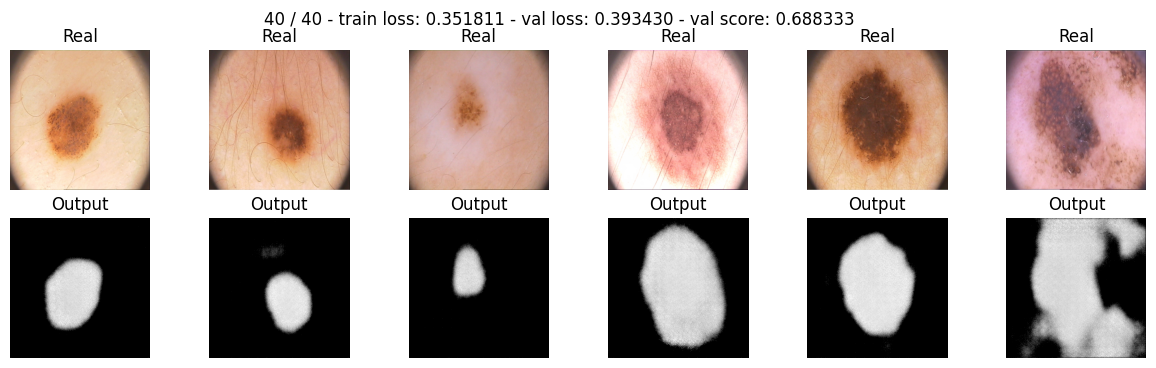

In [ ]:
max_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, compute_score=True)
#2 min

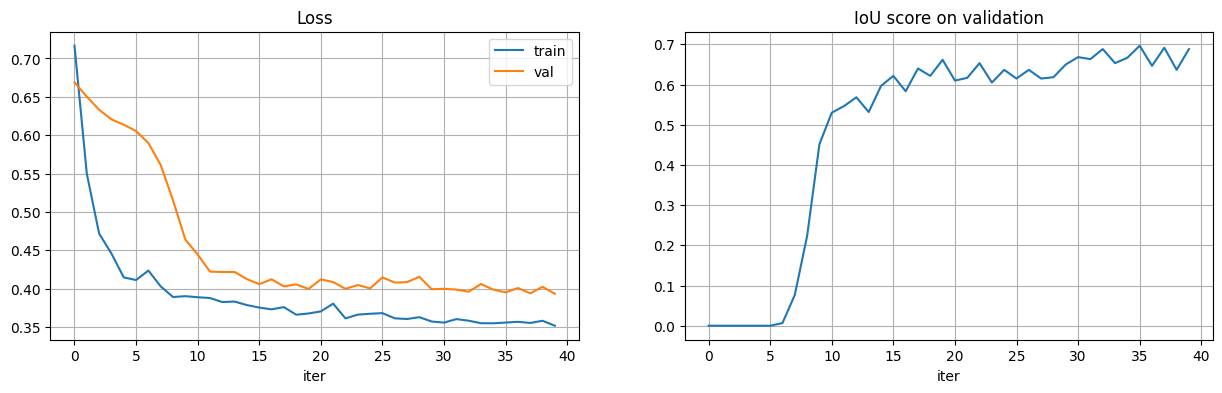

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.grid()
plt.title('Loss')
plt.xlabel('iter')

plt.subplot(1, 2, 2)
plt.plot(scores)
plt.title('IoU score on validation')
plt.xlabel('iter')
plt.grid()
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6883333325386047

In [ ]:
score_model(model, iou_pytorch, data_ts)

0.7733333706855774

In [ ]:
score_model(model, iou_pytorch, data_tr)

0.9190000772476197

In [ ]:
score_model_rotated(model, iou_pytorch, data_ts)

0.7099999984105428

In [ ]:
torch.save(model.state_dict(), 'cnn_transpose.pth')

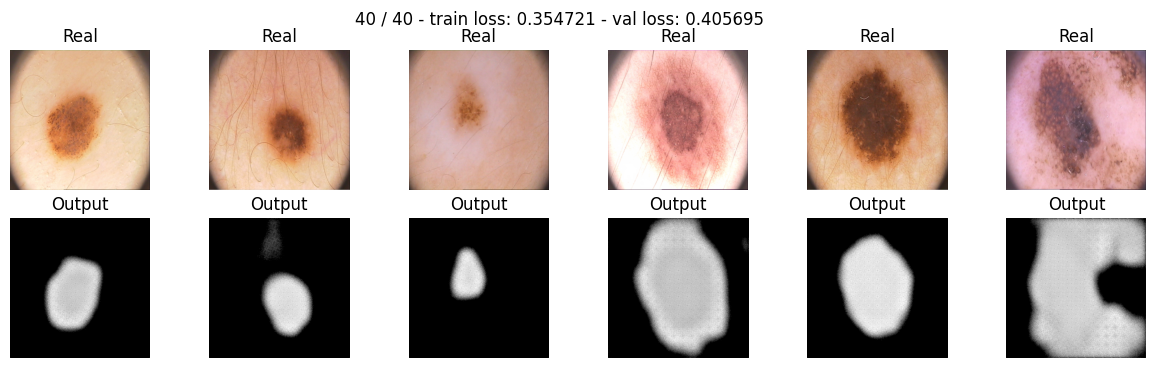

In [ ]:
max_epochs = 40
optimizer = torch.optim.Adam(p4_model.parameters(), lr=0.0001)
train_loss, val_loss, scores = train(p4_model, optimizer, bce_loss, max_epochs, data_tr, data_val, compute_score=True)
#3 min

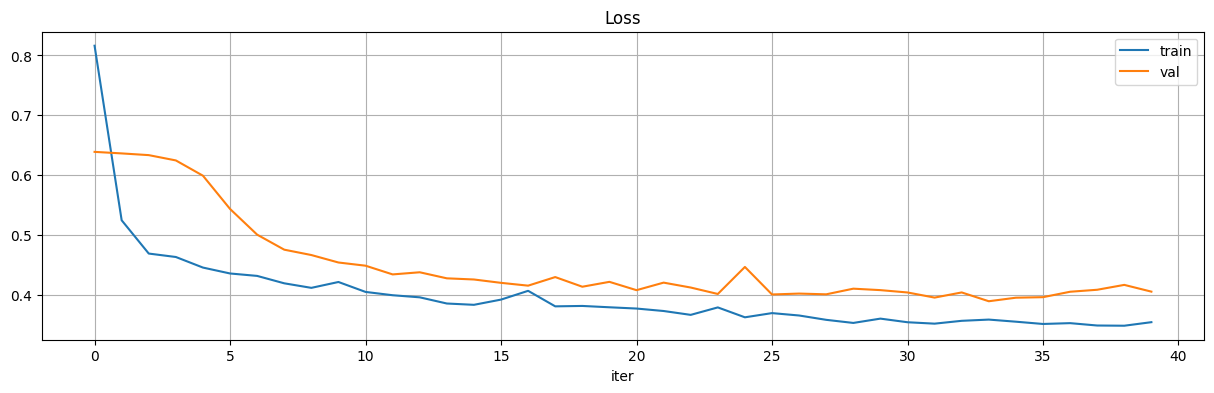

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title('Loss')
plt.xlabel('iter')
plt.grid()
#plt.ylim([0, 0.5])
plt.show()

In [ ]:
score_model(p4_model, iou_pytorch, data_val)

0.6966666777928671

In [ ]:
score_model(p4_model, iou_pytorch, data_tr)

0.8390000224113464

In [ ]:
score_model(p4_model, iou_pytorch, data_ts)

0.7366666793823242

In [ ]:
score_model_rotated(p4_model, iou_pytorch, data_ts)

0.7366666793823242

In [ ]:
torch.save(p4_model.state_dict(), 'p4_transpose.pth')

In [ ]:
#p4_model = GroupSegNetTranspose().to(device)
#p4_model.load_state_dict(torch.load('p4_transpose.pth'))

<All keys matched successfully>

In [ ]:
batch = next(iter(data_val))
val_image = batch[0][:1]
val_image[0, :, 100:150, 100:150] *= 0.1
rot_image = rotate(val_image, r=1)

In [ ]:
p4_model.eval()
model.eval()

output = p4_model.before_pooling(val_image)
rot_output = p4_model.before_pooling(rot_image)

pred_mask = p4_model(val_image).detach().cpu().numpy()
rot_pred_mask = p4_model(rot_image).detach().cpu().numpy()

cnn_mask = model(val_image).detach().cpu().numpy()
rot_cnn_mask = model(rot_image).detach().cpu().numpy()

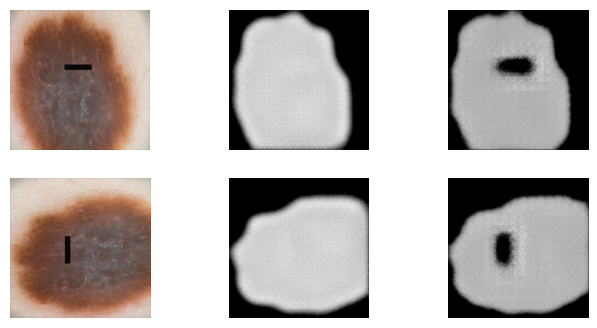

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(2, 3, 1)
plt.axis("off")
plt.imshow(val_image[0].permute(1, 2, 0))
plt.subplot(2, 3, 4)
plt.axis("off")
plt.imshow(rot_image[0].permute(1, 2, 0))
plt.subplot(2, 3, 2)
plt.axis("off")
plt.imshow(pred_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 5)
plt.axis("off")
plt.imshow(rot_pred_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 3)
plt.axis("off")
plt.imshow(cnn_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 6)
plt.axis("off")
plt.imshow(rot_cnn_mask[0, 0], cmap='gray');

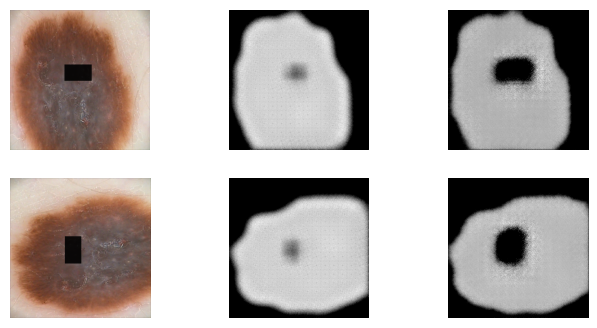

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(2, 3, 1)
plt.axis("off")
plt.imshow(val_image[0].permute(1, 2, 0))
plt.subplot(2, 3, 4)
plt.axis("off")
plt.imshow(rot_image[0].permute(1, 2, 0))
plt.subplot(2, 3, 2)
plt.axis("off")
plt.imshow(pred_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 5)
plt.axis("off")
plt.imshow(rot_pred_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 3)
plt.axis("off")
plt.imshow(cnn_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 6)
plt.axis("off")
plt.imshow(rot_cnn_mask[0, 0], cmap='gray');

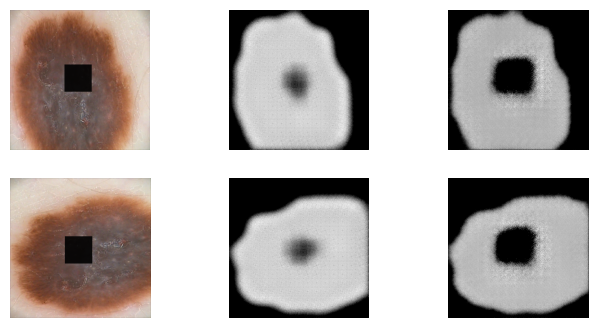

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(2, 3, 1)
plt.axis("off")
plt.imshow(val_image[0].permute(1, 2, 0))
plt.subplot(2, 3, 4)
plt.axis("off")
plt.imshow(rot_image[0].permute(1, 2, 0))
plt.subplot(2, 3, 2)
plt.axis("off")
plt.imshow(pred_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 5)
plt.axis("off")
plt.imshow(rot_pred_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 3)
plt.axis("off")
plt.imshow(cnn_mask[0, 0], cmap='gray')
plt.subplot(2, 3, 6)
plt.axis("off")
plt.imshow(rot_cnn_mask[0, 0], cmap='gray');

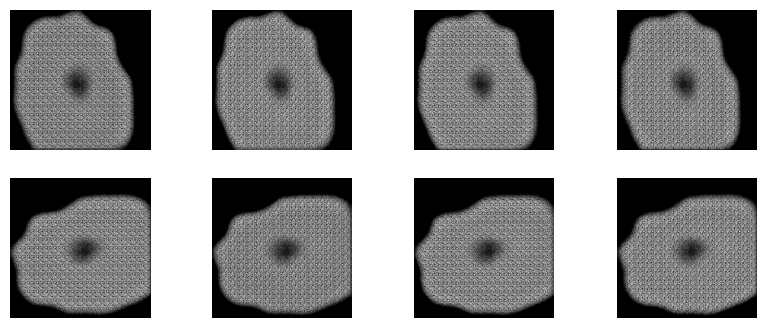

In [ ]:
plt.figure(figsize=(10, 4))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(output[0, 0, i].detach().cpu().numpy(), cmap='gray')

    plt.subplot(2, 4, i+5)
    plt.axis("off")
    plt.imshow(rot_output[0, 0, i].detach().cpu().numpy(), cmap='gray')
plt.show();

In [ ]:
d4_model = GroupSegNetTranspose(channels=[1, 16, 32, 64, 64], group='d4').to(device)
summary(d4_model, (3, 257, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     LiftingConv2d-1      [-1, 16, 8, 257, 257]             448
              ReLU-2      [-1, 16, 8, 257, 257]               0
       BatchNorm3d-3      [-1, 16, 8, 257, 257]              32
       GroupConv2d-4      [-1, 16, 8, 257, 257]          18,448
              ReLU-5      [-1, 16, 8, 257, 257]               0
       BatchNorm3d-6      [-1, 16, 8, 257, 257]              32
         MaxPool3d-7      [-1, 16, 8, 129, 129]               0
       GroupConv2d-8      [-1, 32, 8, 129, 129]          36,896
              ReLU-9      [-1, 32, 8, 129, 129]               0
      BatchNorm3d-10      [-1, 32, 8, 129, 129]              64
      GroupConv2d-11      [-1, 32, 8, 129, 129]          73,760
             ReLU-12      [-1, 32, 8, 129, 129]               0
      BatchNorm3d-13      [-1, 32, 8, 129, 129]              64
        MaxPool3d-14        [-1, 32, 8,

In [ ]:
#Equivariance check
r = 2

train_img = torch.randn(1, 3, 257, 257)
pred_mask = d4_model(train_img)
flipped_mask = torch.flip(pred_mask, dims=[-2])
rotated_mask = rotate(pred_mask, r=r)

rotated_img = rotate(train_img, r=r)
flipped_img = torch.flip(train_img, dims=[-2])

pred_rotated_mask = d4_model(rotated_img)
pred_flipped_mask = d4_model(flipped_img)

print(torch.max(torch.abs(flipped_mask - pred_flipped_mask)))
print(torch.max(torch.abs(rotated_mask - pred_rotated_mask)))
assert torch.allclose(rotated_mask, pred_rotated_mask, atol=1e-4, rtol=1e-4)
assert torch.allclose(flipped_mask, pred_flipped_mask, atol=1e-4, rtol=1e-4)

tensor(5.3883e-05, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(6.2943e-05, device='cuda:0', grad_fn=<MaxBackward1>)


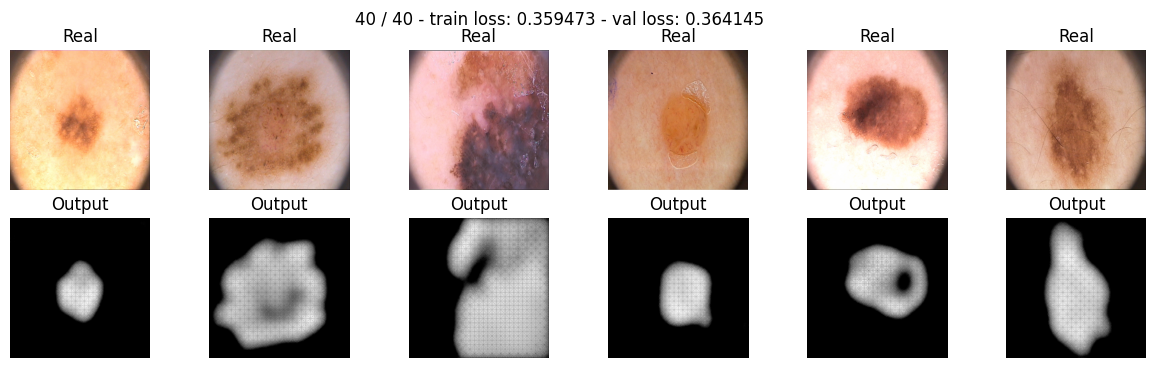

In [ ]:
max_epochs = 40
optimizer = torch.optim.Adam(d4_model.parameters(), lr=0.0001)
train_loss, val_loss = train(d4_model, optimizer, bce_loss, max_epochs, data_tr, data_val)
#8 min

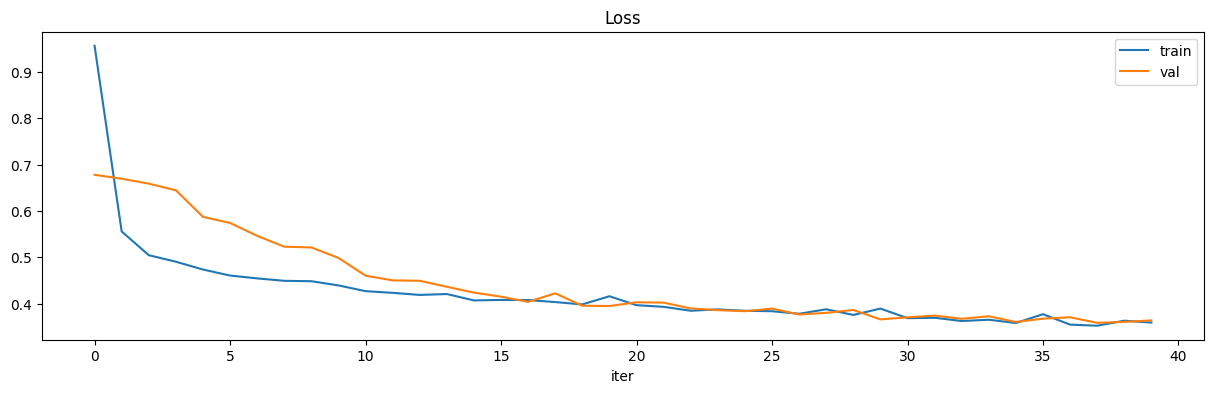

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title('Loss')
plt.xlabel('iter')
#plt.ylim([0, 0.5])
plt.show()

In [ ]:
torch.save(d4_model.state_dict(), 'd4_transpose.pth')

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
score = score_model(model, iou_pytorch, data_val)
print('CNN score on val: ', score)
score = score_model(p4_model, iou_pytorch, data_val)
print('P4 CNN score on val: ', score)
score = score_model(d4_model, iou_pytorch, data_val)
print('D4 CNN score on val: ', score)

CNN score on val:  0.6900000174840292
P4 CNN score on val:  0.7316666841506958
D4 CNN score on val:  0.746666689713796


In [ ]:
score = score_model(model, iou_pytorch, data_ts)
print('CNN score on test: ', score)
score = score_model(p4_model, iou_pytorch, data_ts)
print('P4 CNN score on test: ', score)
score = score_model(d4_model, iou_pytorch, data_ts)
print('D4 CNN score on test: ', score)

CNN score on test:  0.6566667159398397
P4 CNN score on test:  0.6700000365575155
D4 CNN score on test:  0.6933333873748779


In [ ]:
score = score_model(model, iou_pytorch, data_tr)
print('CNN score on train: ', score)
score = score_model(p4_model, iou_pytorch, data_tr)
print('P4 CNN score on train: ', score)
score = score_model(d4_model, iou_pytorch, data_tr)
print('D4 CNN score on train: ', score)

CNN score on train:  0.8290000200271607
P4 CNN score on train:  0.8520000576972961
D4 CNN score on train:  0.8340000152587891


In [ ]:
#d4_model = GroupSegNetTranspose(channels=[1, 16, 32, 64, 64], group='d4').to(device)
#d4_model.load_state_dict(torch.load('d4_transpose.pth'))

<All keys matched successfully>

In [ ]:
batch = next(iter(data_val))
val_image = batch[0][:1]
rot_image = rotate(val_image, r=1)

In [ ]:
d4_model.eval()
output = d4_model.before_pooling(val_image)
rot_output = d4_model.before_pooling(rot_image)

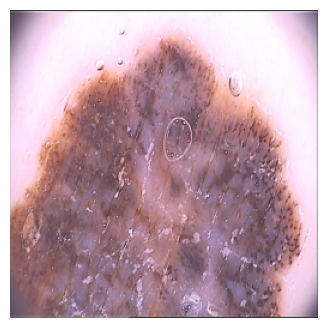

In [ ]:
plt.axis("off")
plt.imshow(val_image[0].permute(1, 2, 0));

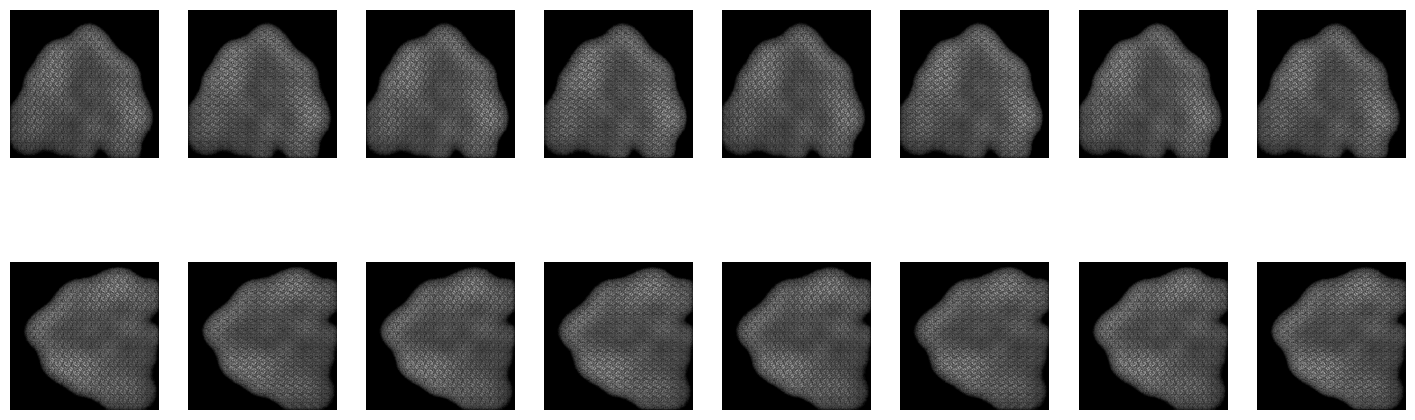

In [ ]:
plt.figure(figsize=(18, 6))

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.axis("off")
    plt.imshow(output[0, 0, i].detach().cpu().numpy(), cmap='gray')

    plt.subplot(2, 8, i+9)
    plt.axis("off")
    plt.imshow(rot_output[0, 0, i].detach().cpu().numpy(), cmap='gray')
plt.show();

### Additional experiments

In [ ]:
class GroupSegNetTransposeSmall(nn.Module):
    def __init__(self, input_channels: int = 3, channels: tuple = None, group: str = 'pn', n: int = 4):
        super().__init__()

        if channels is None:
          channels = [1, 16, 32, 64, 128]
        if group == 'pn':
          stabilizer_size = n
        elif group == 'd4':
          stabilizer_size = 8

        self.enc_blocks = [nn.Sequential(LiftingConv2d(input_channels, channels[1], 3, padding=1, group=group, n=n),
                                          nn.ReLU(),
                                          nn.BatchNorm3d(channels[1]),
                                          GroupConv2d(channels[1], channels[1], 3, padding=1, group=group, n=n),
                                          nn.ReLU(),
                                          nn.BatchNorm3d(channels[1]),
                                          nn.MaxPool3d((1, 5, 5), (1, 4, 4), (0, 2, 2)))]

        for i in range(2, len(channels)):
          self.enc_blocks.append(nn.Sequential(GroupConv2d(channels[i - 1], channels[i], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               nn.MaxPool3d((1, 3, 3), (1, 2, 2), (0, 1, 1))))

        self.enc_blocks = nn.ModuleList(self.enc_blocks)

        self.dec_blocks = []
        for i in range(len(channels) - 1, 0, -1):
          if i != 1:
            stride = 2
          else:
            stride = 4
          self.dec_blocks.append(nn.Sequential(GroupConvTranspose2d(channels[i], channels[i], 3, stride=stride, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i]),
                                               GroupConv2d(channels[i], channels[i - 1], 3, padding=1, group=group, n=n),
                                               nn.ReLU(),
                                               nn.BatchNorm3d(channels[i - 1])))

        self.dec_blocks = nn.ModuleList(self.dec_blocks)
        self.pooling = nn.MaxPool3d((stabilizer_size, 1, 1), (1, 1, 1), (0, 0, 0))


    def forward(self, input):
        # encoder
        x = input.to(device)
        for block in self.enc_blocks:
          x = block(x)

        # decoder
        for block in self.dec_blocks:
          x = block(x)

        output = self.pooling(x)
        return output.reshape(output.shape[0], output.shape[1]*output.shape[2], *output.shape[3:])

    def before_pooling(self, input):
        with torch.no_grad():
          x = input.to(device)
          for block in self.enc_blocks:
            x = block(x)

          # decoder
          for block in self.dec_blocks:
            x = block(x)

        return x

In [ ]:
d4_model = GroupSegNetTransposeSmall(channels=[1, 16, 32, 64, 64], group='d4').to(device)
summary(d4_model, (3, 257, 257))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     LiftingConv2d-1      [-1, 16, 8, 257, 257]             448
              ReLU-2      [-1, 16, 8, 257, 257]               0
       BatchNorm3d-3      [-1, 16, 8, 257, 257]              32
       GroupConv2d-4      [-1, 16, 8, 257, 257]          18,448
              ReLU-5      [-1, 16, 8, 257, 257]               0
       BatchNorm3d-6      [-1, 16, 8, 257, 257]              32
         MaxPool3d-7        [-1, 16, 8, 65, 65]               0
       GroupConv2d-8        [-1, 32, 8, 65, 65]          36,896
              ReLU-9        [-1, 32, 8, 65, 65]               0
      BatchNorm3d-10        [-1, 32, 8, 65, 65]              64
      GroupConv2d-11        [-1, 32, 8, 65, 65]          73,760
             ReLU-12        [-1, 32, 8, 65, 65]               0
      BatchNorm3d-13        [-1, 32, 8, 65, 65]              64
        MaxPool3d-14        [-1, 32, 8,

In [ ]:
d4_model = GroupSegNetTransposeSmall(channels=[1, 16, 32, 64, 64], group='d4').to(device)

max_epochs = 40
optimizer = torch.optim.Adam(d4_model.parameters(), lr=0.0001)
loss_func = torch.nn.BCELoss()
train_loss, val_loss = train(d4_model, optimizer, loss_func, max_epochs, data_tr, data_val)
#4 min

RuntimeError: ignored

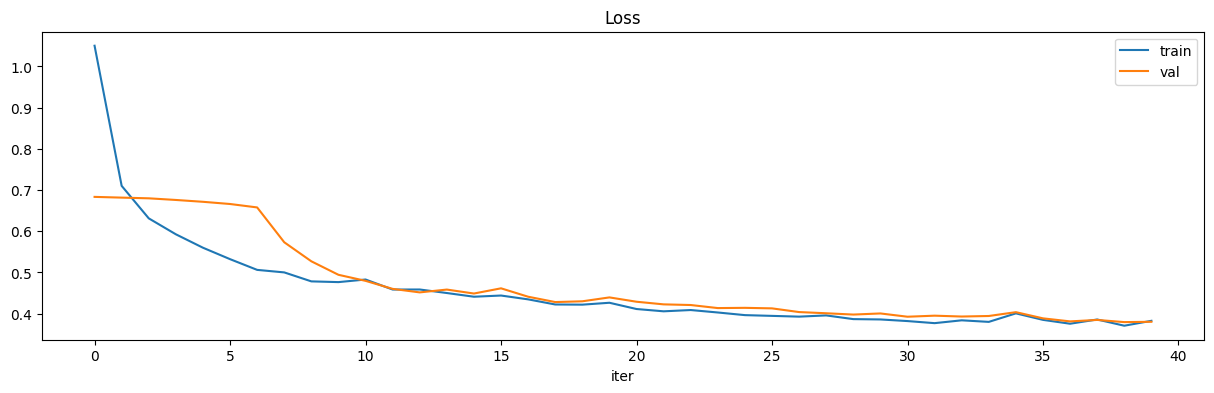

In [ ]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.title('Loss')
plt.xlabel('iter')
#plt.ylim([0, 0.5])
plt.show()

In [ ]:
score = score_model(d4_model, iou_pytorch, data_tr)
print('D4 CNN score on train: ', score)

D4 CNN score on train:  0.8230000257492065


In [ ]:
score = score_model(d4_model, iou_pytorch, data_ts)
print('D4 CNN score on test: ', score)

D4 CNN score on test:  0.725000003973643


# Filters

In [ ]:
batch = next(iter(data_val))
val_image = batch[0][:1]
rot_image = rotate(val_image, r=1)

In [ ]:
p4_model.eval()
output = p4_model.before_pooling(val_image)
rot_output = p4_model.before_pooling(rot_image)

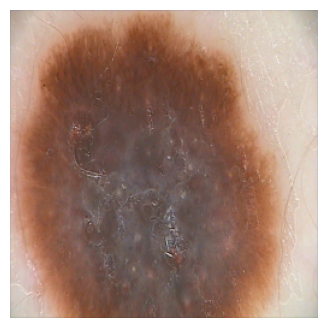

In [ ]:
plt.axis("off")
plt.imshow(val_image[0].permute(1, 2, 0));

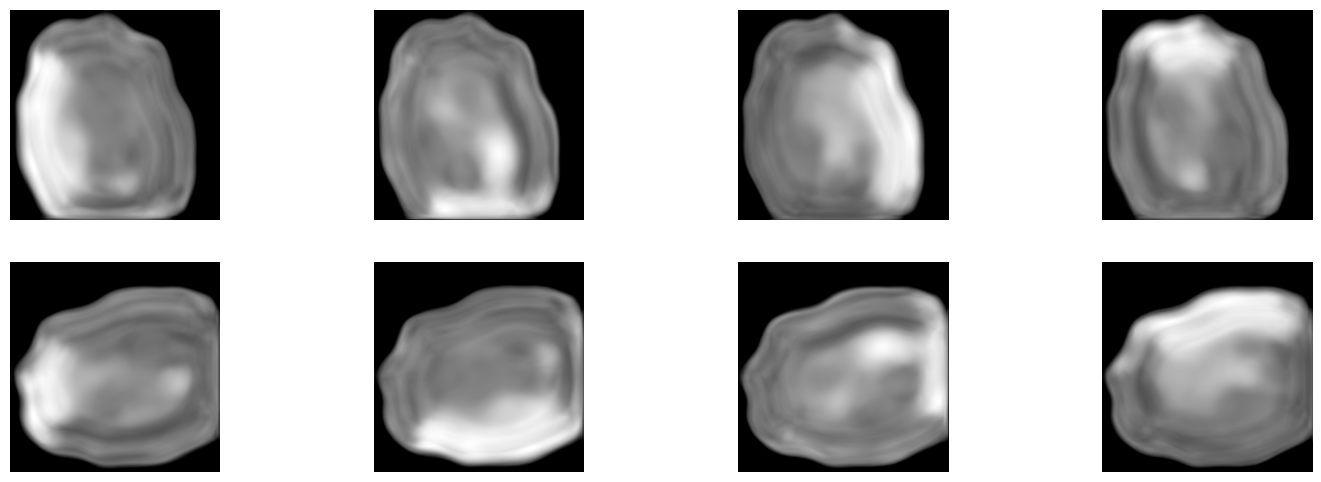

In [ ]:
plt.figure(figsize=(18, 6))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(output[0, 0, i].detach().cpu().numpy(), cmap='gray')

    plt.subplot(2, 4, i+5)
    plt.axis("off")
    plt.imshow(rot_output[0, 0, i].detach().cpu().numpy(), cmap='gray')
plt.show();

In [ ]:
lift_input = p4_model.enc_layers[2](p4_model.enc_layers[1](p4_model.enc_layers[0](val_image.to(device))))

In [ ]:
output = p4_model.enc_layers[3][0](lift_input)

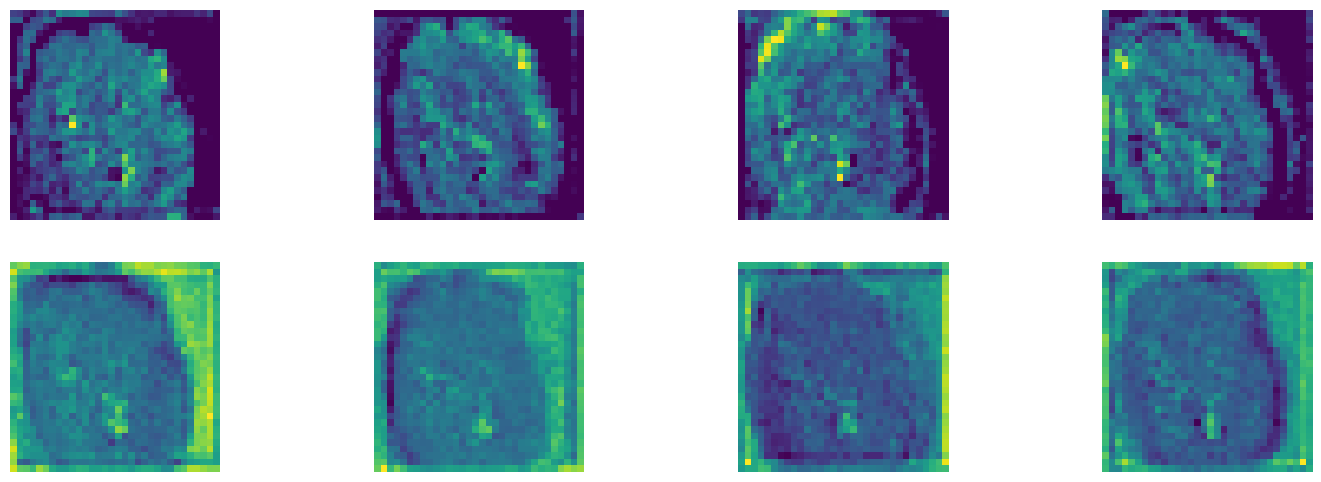

In [ ]:
plt.figure(figsize=(18, 6))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(lift_input[0, 0, i].detach().cpu().numpy())

    plt.subplot(2, 4, i+5)
    plt.axis("off")
    plt.imshow(output[0, 0, i].detach().cpu().numpy())

plt.show();

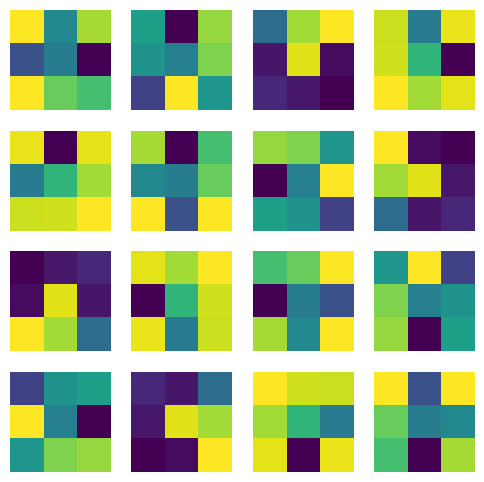

In [ ]:
filters = p4_model.enc_layers[2][0].weight

plt.figure(figsize=(6, 6))
for i in range(4):
  for j in range(4):
    plt.subplot(4, 4, i+1 + 4*j)
    plt.axis("off")
    plt.imshow(rotate_pn(filters, j)[0, 0, i].detach().cpu().numpy())

plt.show();

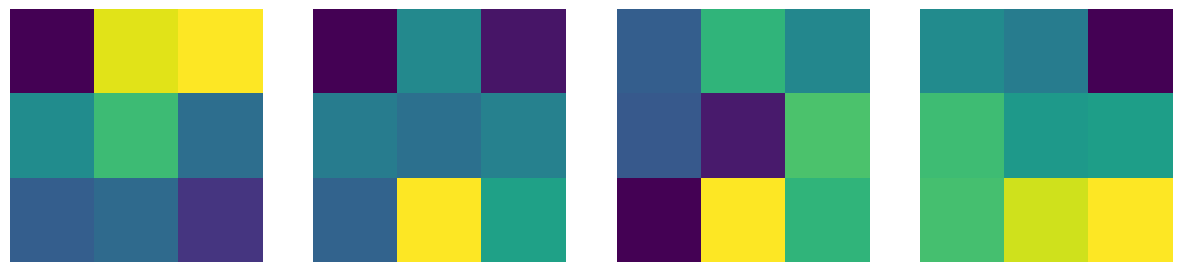

In [ ]:
filters = p4_model.enc_layers[0][3].weight

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.axis("off")
    plt.imshow(filters[0, 0, i].detach().cpu().numpy())

   # plt.subplot(2, 4, i+5)
   # plt.axis("off")
   # plt.imshow(rot_output[0, 0, i].detach().cpu().numpy(), cmap='gray')
plt.show();

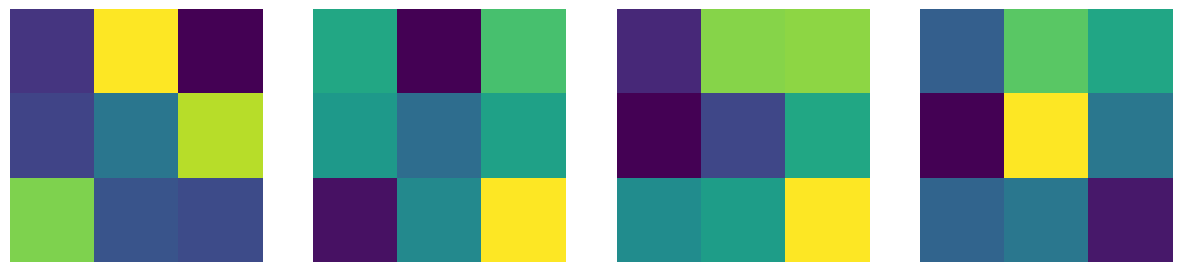

In [ ]:
filters = p4_model.dec_layers[3][3].weight

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.axis("off")
    plt.imshow(filters[0, 0, i].detach().cpu().numpy())

   # plt.subplot(2, 4, i+5)
   # plt.axis("off")
   # plt.imshow(rot_output[0, 0, i].detach().cpu().numpy(), cmap='gray')
plt.show();

In [ ]:
d4_model.eval()
output = d4_model.before_pooling(val_image)
rot_output = d4_model.before_pooling(rot_image)

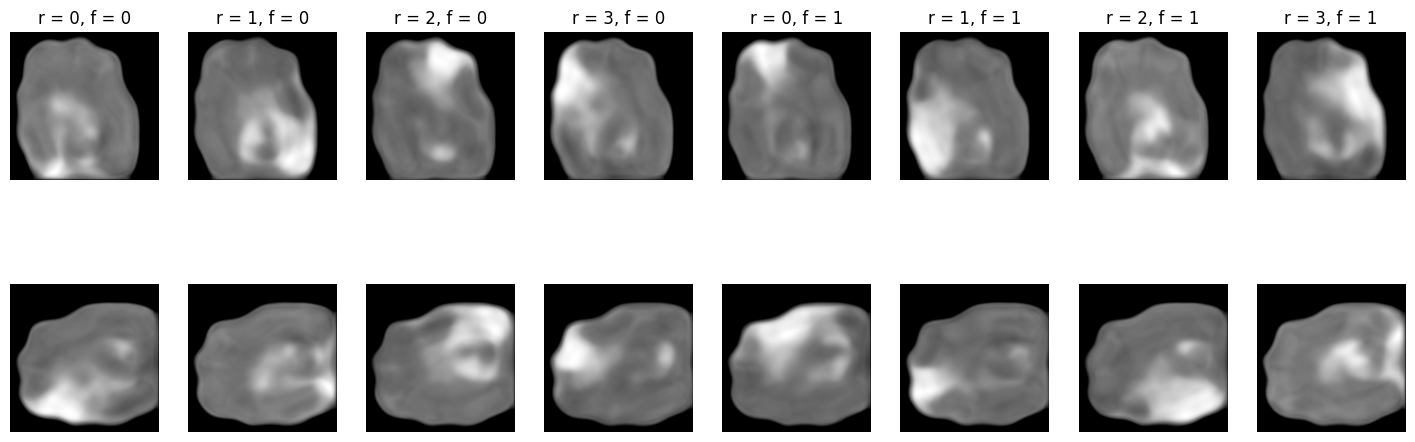

In [ ]:
plt.figure(figsize=(18, 6))

for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.axis("off")
    plt.imshow(output[0, 0, i].detach().cpu().numpy(), cmap='gray')
    plt.title('r = {}, f = {}'.format(i % 4, i // 4))

    plt.subplot(2, 8, i+9)
    plt.axis("off")
    plt.imshow(rot_output[0, 0, i].detach().cpu().numpy(), cmap='gray')
plt.show();